In [1]:
import sys
import os
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import logsumexp
sys.path.append('vbpi-torch/rooted')

import torch
from dataManipulation import *
from treeManipulation import *
from utils import tree_summary, summary, summary_raw, get_support_info
from vbpi import VBPI

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree_torch import Tree
from SLCVI_torch import SLCVI

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

In [3]:
data_set = "DS2"
pop_size = 5.0 # exponential parameter for constant pop size prior

# initialize models
models = {"reinforce": {},
          "reparam": {},
          "VIMCO": {},
          "VBPI": {}}

data_file = '../dat/'+data_set+'/'+data_set+'.pickle'

# models
models = ["reparam","reinforce","BEAST","VBPI"]

# Beast file
BEAST_pref = '../dat/'+data_set+'/'+data_set+'_MLL_'
BEAST_burnin = 250000

# VPBI files
VBPI_dir = '../results/'+data_set+'/'

# Requirements for VBPI

In [4]:
# load the sequence data and estimate the subsplit support
data, taxa = loadData('../dat/'+data_set+'/'+data_set+'.nexus', 'nexus')
mcmc_support_trees_dict, mcmc_support_trees_wts = summary('../dat/'+data_set+'/'+data_set+'_fixed_pop_support_short_run', 'nexus', burnin=250)
rootsplit_supp_dict, subsplit_supp_dict = get_support_info(taxa, mcmc_support_trees_dict)
#del mcmc_support_trees_dict, mcmc_support_trees_wts

In [5]:
# load the ground truth
#mcmc_sampled_trees_dict, mcmc_sampled_trees_wts, _ = tree_summary('../dat/DS1/DS1_fixed_pop_golden_run.trees', 'nexus', burnin=25001)
emp_tree_freq = None#{mcmc_sampled_trees_dict[tree_id]: tree_wts for tree_id, tree_wts in sorted(mcmc_sampled_trees_wts.items(), key=lambda x:x[1], reverse=True)}
sample_info = [0.0 for taxon in taxa]
#del mcmc_sampled_trees_dict, mcmc_sampled_trees_wts

In [6]:
# set up the model
VBPI_models = {}
VBPI_models["10"] = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

VBPI_models["20"] = VBPI(taxa, rootsplit_supp_dict, subsplit_supp_dict, data, pden=np.ones(4)/4., subModel=('JC', 1.0),
             emp_tree_freq=emp_tree_freq, root_height_offset=0.0, clock_rate=1.0, psp=True,
             sample_info=sample_info, coalescent_type='fixed_pop', clock_type='fixed_rate',
             log_pop_size_offset=math.log(5.0))

# Load in the relevant files

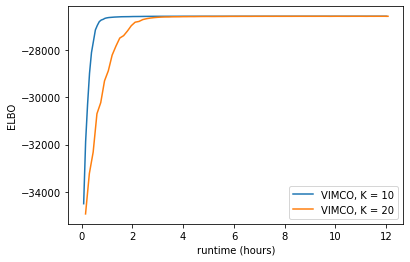

In [7]:
# VBPI
VBPI_runtimes = {}
VBPI_lbs = {}
VBPI_iters = {}

legend = []

for bs in ["10","20"]:
    
    VBPI_runtimes[bs] = None
    VBPI_lbs[bs] = None
    VBPI_iters[bs] = None
    lb_star = -np.infty
    
    for ss in ["0.001","0.0001","1e-05"]:
        VBPI_pref = "mcmc_vimco_%s_%s_psp_fixed_pop_fixed_rate_"%(bs,ss)
        files = [x for x in os.listdir(VBPI_dir) if x.startswith(VBPI_pref)]
        
        VBPI_runtimes0 = np.load(VBPI_dir+max([x for x in files if x.endswith("_run_time.npy")]))
        VBPI_lbs0 = np.load(VBPI_dir+max([x for x in files if x.endswith("_test_lb.npy")]))
        VBPI_iters0 = np.load(VBPI_dir+max([x for x in files if x.endswith("_iters.npy")]))
        
        if max(VBPI_lbs0) > lb_star:
            VBPI_runtimes[bs] = VBPI_runtimes0
            VBPI_lbs[bs] = VBPI_lbs0
            VBPI_iters[bs] = VBPI_iters0
            VBPI_models[bs].load_from(VBPI_dir+max([x for x in files if x.endswith(".pt")]))
            lb_star = max(VBPI_lbs0)
            
    plt.plot(np.cumsum(VBPI_runtimes[bs])/3600,VBPI_lbs[bs])
    plt.xlabel("runtime (hours)")
    #plt.plot(VBPI_iters[bs],VBPI_lbs[bs])
    #plt.xlabel("Iteration")
    legend.append("VIMCO, K = %s"%(bs))  

plt.ylabel("ELBO")
plt.legend(legend)

In [8]:
# BEAST
def load_beast(data_set,i,burnin):
    df = pd.read_csv('../dat/'+data_set+'/'+data_set+'_fixed_pop_MLL_%d.log'%i, 
                     sep = '\t',skiprows=[0,1,2])
    df = df[df.state > burnin]
    return df

BEAST_data = pd.concat([load_beast(data_set,i,BEAST_burnin) for i in range(1,11)])
BEAST_MLLs = []

# extract MLL from beast log
for i in range(1,11):
    with open('../dat/'+data_set+'/'+data_set+"_MLL_%d.txt"%i, "r") as text_file:
        line = text_file.readlines()[-4]
    ind = np.where([not x in "-1234567890." for x in line])[0][-2]
    BEAST_MLLs.append(float(line[(ind+1):-1]))

In [9]:
# my models
optims = {}
settings = {}
ELBO_star = -np.infty
ELBO_min = np.infty
ELBO_max = -np.infty

for model in ["reinforce","reparam","reinforce_VIMCO"]:
    
    optims[model] = None
    ELBO_star = -np.infty
    
    for ss in [0.03,0.01,0.003]:
    
        for rs in range(10):
            
            optim_dir = '../results/'+data_set+'/'
            optim_pref = data_set+'_'+model+'_'+str(ss)+'_'+str(rs)
            files = [x for x in os.listdir(optim_dir) if x.startswith(optim_pref)]
            
            if not files:
                print(optim_pref + " does not exist. Continuing...")
                continue
            
            fname = optim_dir + max(files)
    
            with open(fname, 'rb') as f:
                optim0 = pickle.load(f)
            
            if optim0.ELBO_ests[-1] > ELBO_star:
                optims[model] = optim0
                settings[model] = (ss,rs)
                ELBO_star = optim0.ELBO_ests[-1]
                
    if max(optims[model].ELBO_ests) > ELBO_max:
        ELBO_max = max(optims[model].ELBO_ests)

    if min(optims[model].ELBO_ests) < ELBO_min:
        ELBO_min = min(optims[model].ELBO_ests)
 

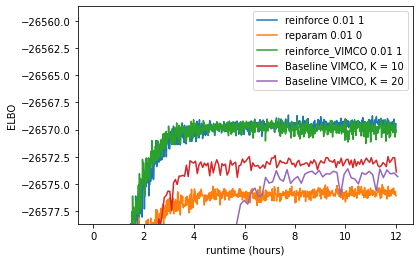

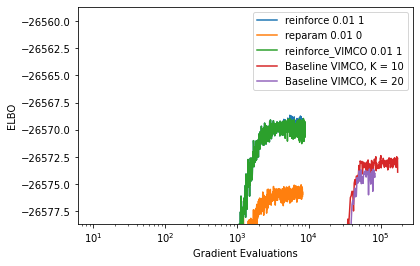

In [10]:
legend = []
for model in ["reinforce","reparam","reinforce_VIMCO"]:
    plt.plot(np.cumsum(optims[model].run_times)/3600,optims[model].ELBO_ests)
    legend.append(model+" "+str(settings[model][0])+" "+str(settings[model][1]))

for bs in ["10","20"]:
    plt.plot(np.cumsum(VBPI_runtimes[bs])/3600,VBPI_lbs[bs])
    legend.append("Baseline VIMCO, K = %s"%(bs))  

plt.xlabel("runtime (hours)")
plt.ylabel("ELBO")
plt.legend(legend)
plt.ylim([ELBO_min-10,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_time.png')
plt.ylim([ELBO_max-10,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_time_zoom.png')
plt.show()

legend = []
for model in ["reinforce","reparam","reinforce_VIMCO"]:
    plt.plot(optims[model].epochs,optims[model].ELBO_ests)
    legend.append(model+" "+str(settings[model][0])+" "+str(settings[model][1]))

for bs in ["10","20"]:
    plt.plot(VBPI_iters[bs],VBPI_lbs[bs])
    legend.append("Baseline VIMCO, K = %s"%(bs))  

plt.xlabel("Gradient Evaluations")
plt.ylabel("ELBO")
plt.legend(legend)

plt.xscale('log')
    
plt.ylim([ELBO_min-10,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_iter.png')
plt.ylim([ELBO_max-10,ELBO_max+10])
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBO_v_iter_zoom.png')
plt.show()

In [11]:
settings

{'reinforce': (0.01, 1), 'reparam': (0.01, 0), 'reinforce_VIMCO': (0.01, 1)}

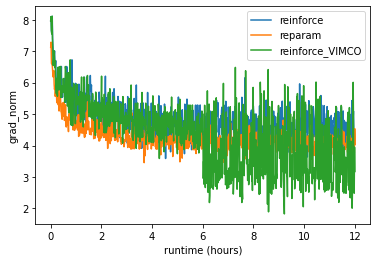

In [12]:
legend = []
    
for model in ["reinforce","reparam","reinforce_VIMCO"]:
                
        plt.plot(np.cumsum(optims[model].run_times)/3600,np.log(optims[model].grad_norms))
        legend.append(model)

plt.xlabel("runtime (hours)")
plt.ylabel("grad_norm")
plt.legend(legend)
plt.savefig('../plt/'+data_set+'/'+data_set+'_grad_norm_v_time.png')

# draw the random tree using a newick file

In [13]:
def write_newick(node):

    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time.item())
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time.item() - node.coal_time.item()
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

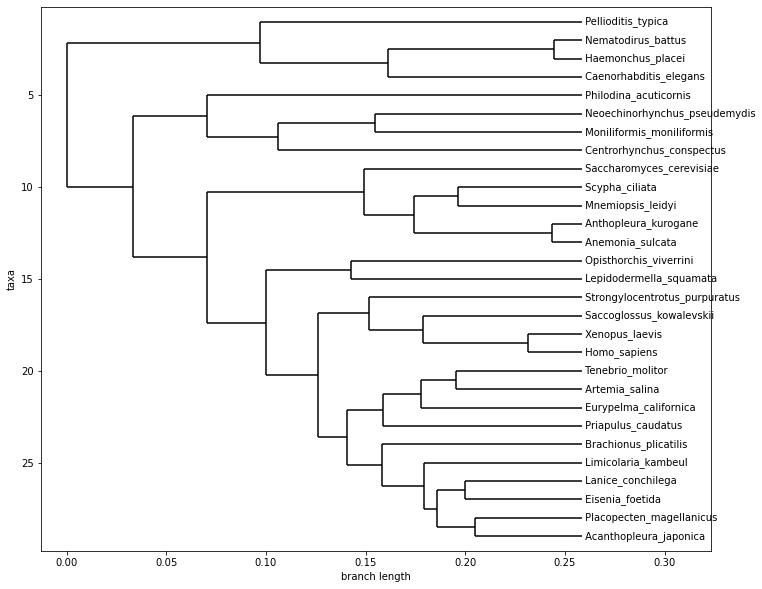

tensor(-26397.7147)
tensor(-51.2626)
tensor(-26448.9773)


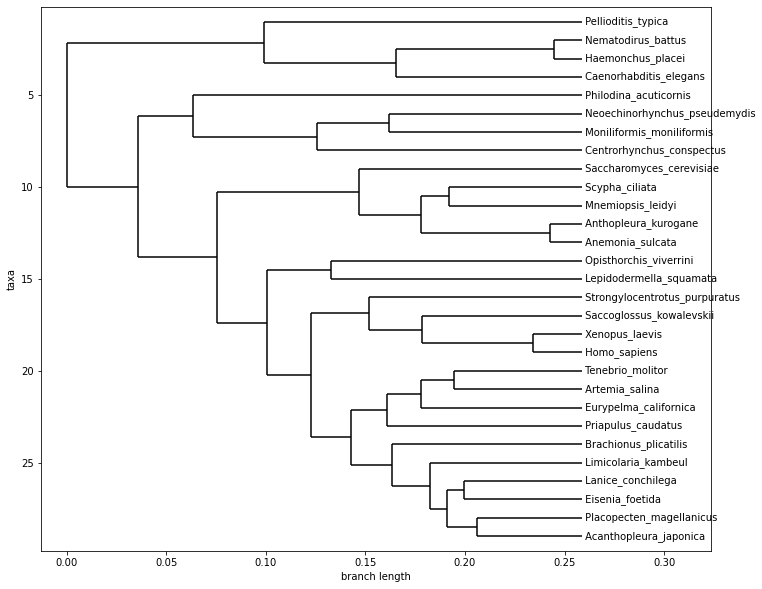

tensor(-26394.1796)
tensor(-51.1761)
tensor(-26445.3557)


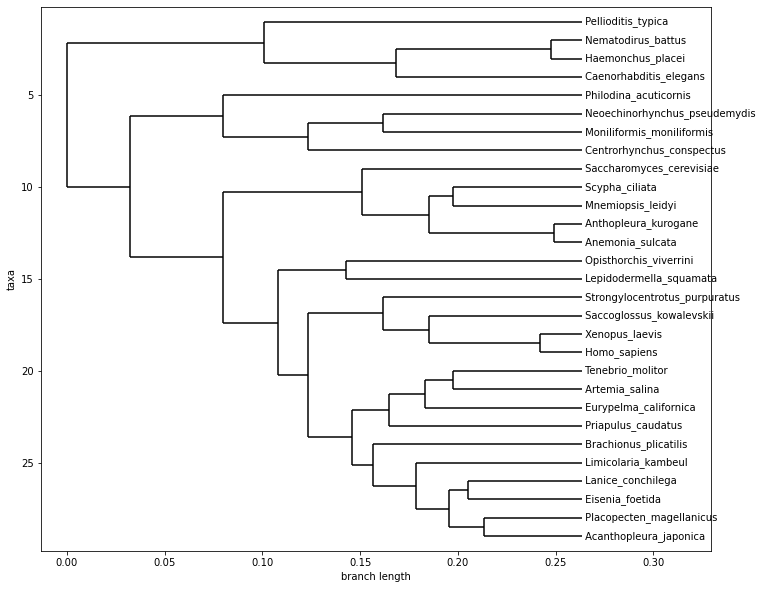

tensor(-26395.2195)
tensor(-51.2033)
tensor(-26446.4228)


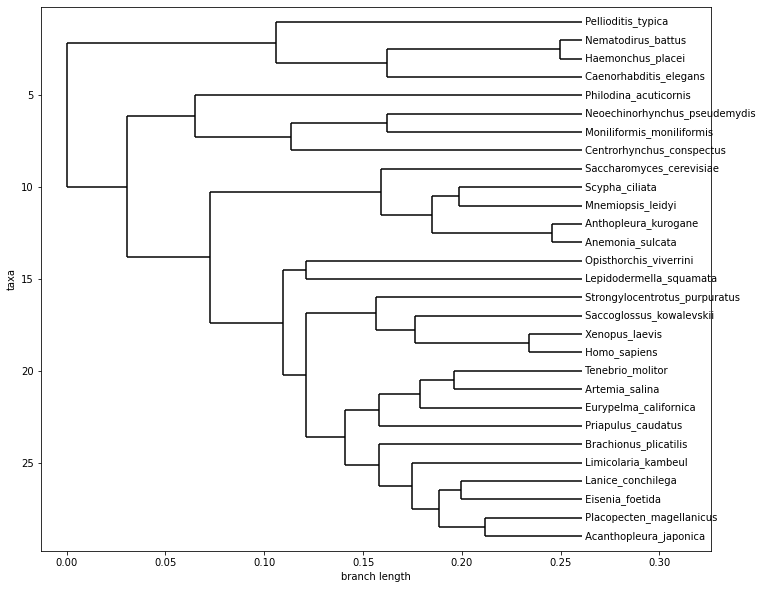

tensor(-26399.8789)
tensor(-51.2793)
tensor(-26451.1582)


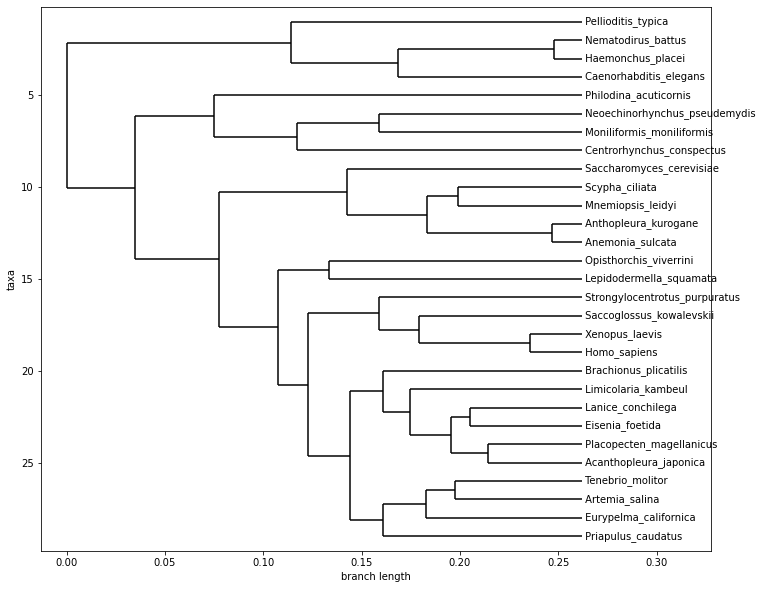

tensor(-26395.9193)
tensor(-51.2313)
tensor(-26447.1507)


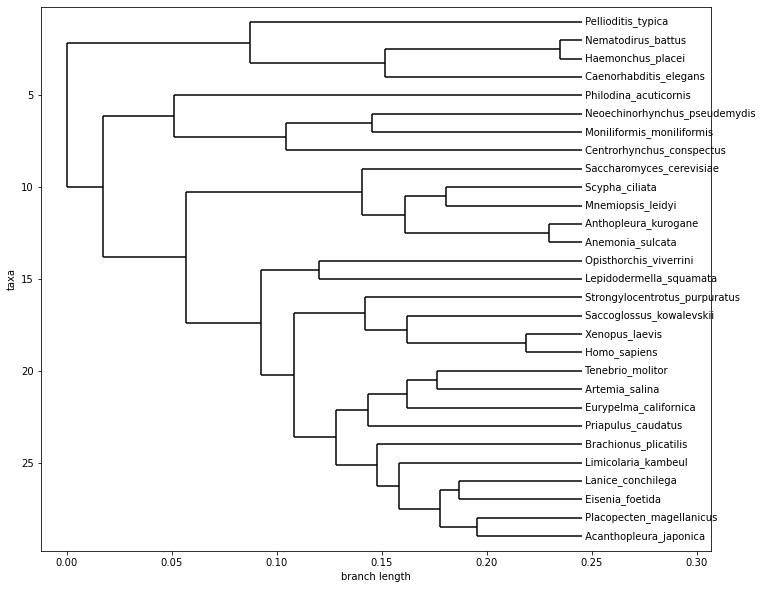

tensor(-26397.5610)
tensor(-51.2433)
tensor(-26448.8043)


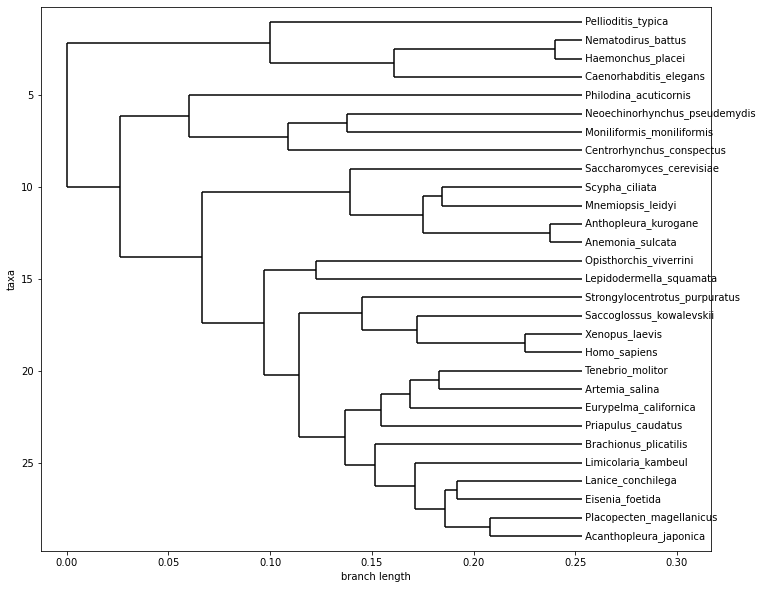

tensor(-26398.1431)
tensor(-51.3209)
tensor(-26449.4640)


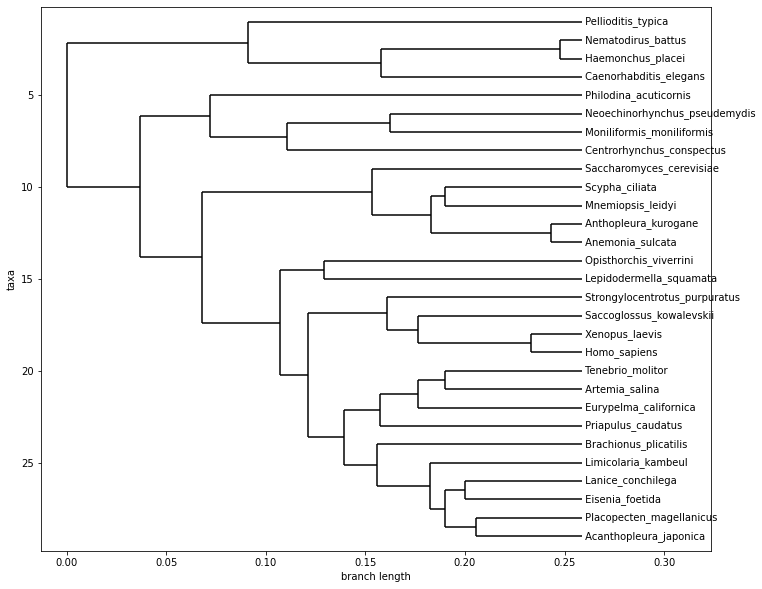

tensor(-26401.2758)
tensor(-51.2412)
tensor(-26452.5170)


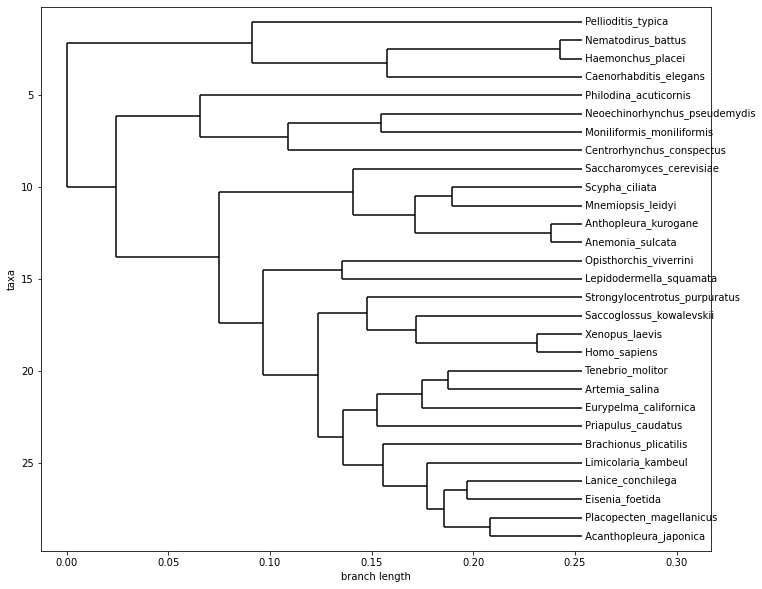

tensor(-26400.0644)
tensor(-51.1068)
tensor(-26451.1712)


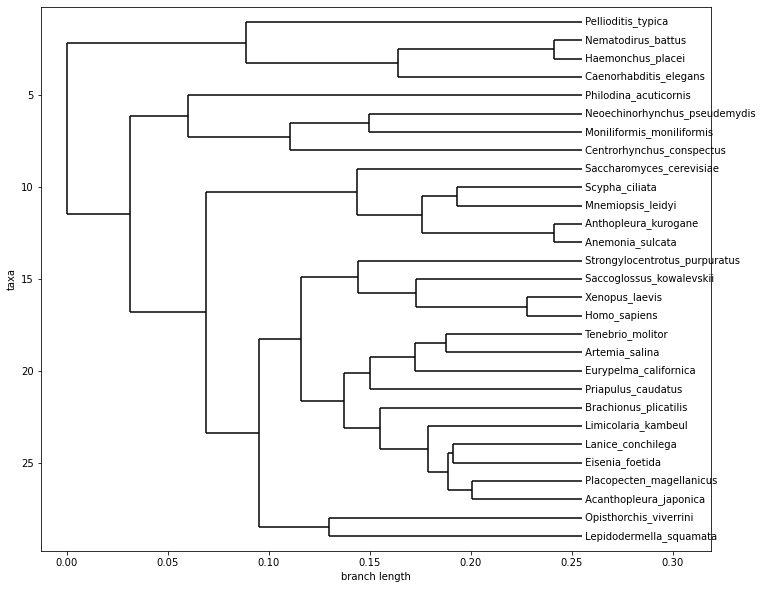

tensor(-26401.4998)
tensor(-51.2932)
tensor(-26452.7930)


In [14]:
theta = torch.tensor(optims['reinforce'].theta)

with open(data_file, 'rb') as f:
    DS = pickle.load(f)

genomes = []
species = []
for key in DS:
    genomes.append(DS[key])
    species.append(key)
    
n_species = len(species)

# From https://github.com/zcrabbit/vbpi-torch/blob/ff86cf0c47a5753f5cc5b4dfe0b6ed783ab22669/unrooted/phyloModel.py#L7-L11
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.], 'n':[1.,1.,1.,1.]}

tree_log_probs = torch.tensor([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = torch.float64)
tree_log_probs = torch.log(tree_log_probs)

for _ in range(10):
    Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
    log_times = torch.exp(theta[1])*Z+theta[0]
    log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
    log_times = log_times.detach()

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)

    print(tree.log_like)
    print(tree.log_prior)
    print(tree.log_p)

# plot estimated ELBO over time

In [15]:
tree_lengths = {}
root_heights = {}
log_likes = {}
log_priors = {}
log_qs = {}
MLLs = {}

# Get data from BEAST

In [16]:
# get lengths from BEAST
tree_lengths["BEAST"] = BEAST_data.treeLength[BEAST_data.state > BEAST_burnin].to_numpy()
root_heights["BEAST"] = BEAST_data['treeModel.rootHeight'][BEAST_data.state > BEAST_burnin].to_numpy()
log_likes["BEAST"] = BEAST_data.likelihood[BEAST_data.state > BEAST_burnin].to_numpy()
log_priors["BEAST"] = BEAST_data.prior[BEAST_data.state > BEAST_burnin].to_numpy()

MLLs["BEAST"] = BEAST_MLLs

# Get data from VBPI

In [17]:
self = VBPI_models["10"]
n_runs = 1000
n_particles = 1

root_heights["VBPI"] = []
tree_lengths["VBPI"] = []
log_priors["VBPI"] = []
log_likes["VBPI"] = []
MLLs["VBPI"] = []

for i in range(n_runs):
    print(i)
    with torch.no_grad():
        samp_trees = [self.tree_model.sample_tree() for particle in range(n_particles)]
        [namenum(tree, self.taxa) for tree in samp_trees]
        logq_tree = torch.stack([self.logq_tree(tree) for tree in samp_trees])

        samp_branch, logq_height, height, event_info = self.branch_model(samp_trees)
        log_clock_rate, logq_clock_rate = self.clock_model.sample(n_particles=n_particles)
        samp_branch = samp_branch.to(torch.float32) * log_clock_rate.exp()
        logll = torch.stack([self.phylo_model.loglikelihood(branch, tree) for branch, tree in zip(*[samp_branch, samp_trees])])

        self.tree_prior_model.update_batch(height, event_info)
        coalescent_param, logq_prior = self.tree_prior_model.sample_pop_size(n_particles=n_particles)
        logp_coalescent_prior, _ = self.tree_prior_model(coalescent_param, False)

        logp_clock_rate = self.clock_model(log_clock_rate)

        # get values
        root_heights["VBPI"].extend(list(height[:,0].numpy()))
        tree_lengths["VBPI"].extend(list(np.sum(samp_branch.numpy(),axis=1)))
        log_priors["VBPI"].extend(list(logp_coalescent_prior.numpy() + logp_clock_rate))
        log_likes["VBPI"].extend(list(logll.numpy()))
        MLLs["VBPI"].append(torch.logsumexp(logll + logp_coalescent_prior + logp_clock_rate - logq_tree - logq_height - logq_prior - logq_clock_rate - math.log(n_particles), 0).item())

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Get data from my code

In [18]:
def get_tree_length(tree):
    tree_length = 0
    for leaf in tree.leaves:
        tree_length += leaf.parent.coal_time.item() - leaf.coal_time

    for node in tree.nodes[:-1]:
        tree_length += node.parent.coal_time.item() - node.coal_time.item()
        
    return tree_length

In [19]:
n_exp = 100
n_particles = 1

for model in ["reparam","reinforce","reinforce_VIMCO"]:
    with torch.no_grad():
        theta = optims[model].theta

        root_heights[model] = []
        tree_lengths[model] = []
        log_priors[model] = []
        log_likes[model] = []
        MLLs[model] = []

        for i in range(n_exp):
            print(i)
            p_minus_qs = []

            for j in range(n_particles):

                Z = torch.normal(mean=0.0,std=1.0,size=(n_species,n_species))
                log_times = torch.exp(theta[1])*Z+theta[0]
                log_times = log_times + torch.triu(torch.full((n_species,n_species), float("Inf")))
                log_times = log_times.detach()
                tree = Tree(theta,log_times,deepcopy(tree_log_probs),
                            pop_size=pop_size)

                p_minus_qs.append(tree.log_p.item() - tree.log_q.item())

                log_likes[model].append(tree.log_like.item())
                log_priors[model].append(tree.log_prior.item())
                root_heights[model].append(tree.nodes[-1].coal_time.item())
                tree_lengths[model].append(get_tree_length(tree))

            MLLs[model].append(logsumexp(p_minus_qs) - np.log(n_particles))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [20]:
def plot_hist(data,title):  
    
    colors = {"BEAST":plt.cm.tab10(0),
              "VBPI":plt.cm.tab10(1),
              "reparam":plt.cm.tab10(2),
              "reinforce":plt.cm.tab10(3),
              "reinforce_VIMCO":plt.cm.tab10(4)}
    
    keys = list(data.keys())
    _, bins, _ = plt.hist(data[keys[0]], bins = 100, alpha = 0.5, density=True, color=colors[keys[0]])

    for key in keys[1:]:
        plt.hist(data[key], bins = bins, alpha = 0.5, density=True, color=colors[key])

    plt.legend(keys)
    plt.xlabel(title)
    plt.ylabel("density")
    plt.savefig('../plt/'+data_set+'/'+data_set+'_'+title+'_hist.png')
    plt.show()

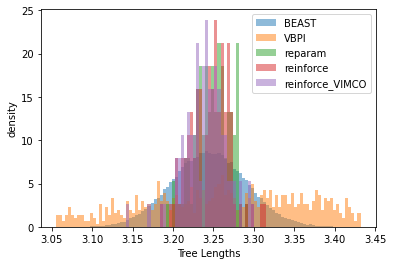

In [21]:
plot_hist(tree_lengths,"Tree Lengths")

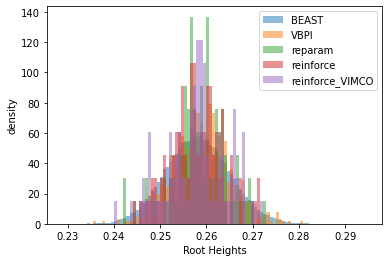

In [22]:
plot_hist(root_heights,"Root Heights")

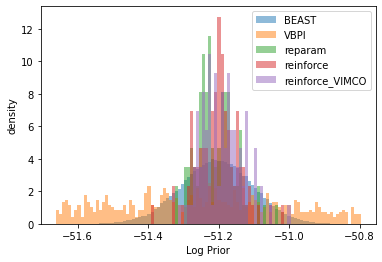

In [23]:
plot_hist(log_priors,"Log Prior")

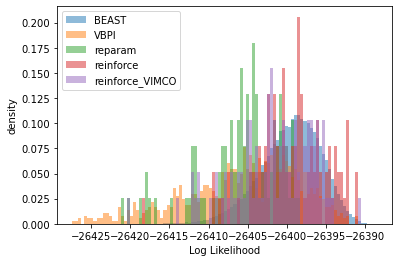

In [24]:
plot_hist(log_likes,"Log Likelihood")

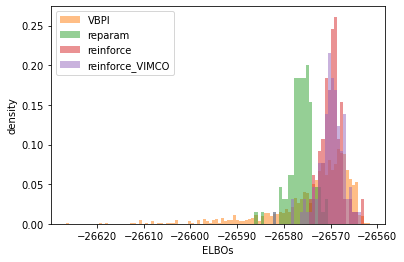

In [25]:
# Create a copy of the dictionary
MLLs0 = MLLs.copy()
del MLLs0['BEAST']
plot_hist(MLLs0,"ELBOs")

In [26]:
list(MLLs.keys())

['BEAST', 'VBPI', 'reparam', 'reinforce', 'reinforce_VIMCO']

MLLs:

BEAST: -26566.56032892307
VBPI: -26566.505271423914
reparam: -26574.046051124642
reinforce: -26566.919874184317
reinforce_VIMCO: -26567.420519476724


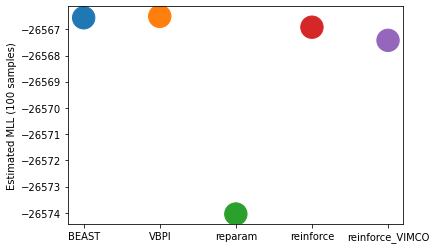

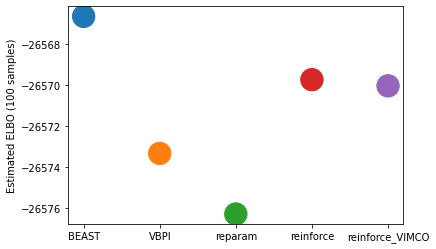

In [27]:
print("MLLs:")
print("")


for key in MLLs:
    print("%s: %s"%(key,logsumexp(MLLs[key]) - np.log(len(MLLs[key]))))
    
data = {'model': [key for key in MLLs], 
        'MLL': [logsumexp(MLLs[key]) - np.log(len(MLLs[key])) for key in MLLs],
        'ELBO': [np.mean(MLLs[key]) for key in MLLs]}
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_csv('../plt/'+data_set+'/'+data_set+'_MLLs.csv', index=False)

plt.scatter(data["model"],data["MLL"],c=[plt.cm.tab10(i) for i in range(5)],s=500)
plt.ylabel("Estimated MLL (100 samples)")
plt.savefig('../plt/'+data_set+'/'+data_set+'_MLLs.png')
plt.show()

plt.scatter(data["model"],data["ELBO"],c=[plt.cm.tab10(i) for i in range(5)],s=500)
plt.ylabel("Estimated ELBO (100 samples)")
plt.savefig('../plt/'+data_set+'/'+data_set+'_ELBOs.png')

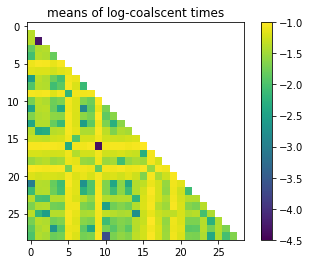

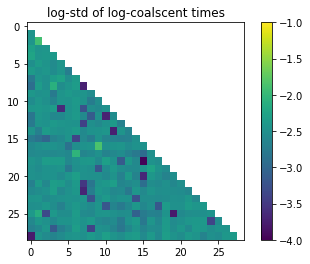

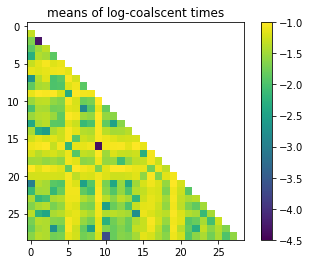

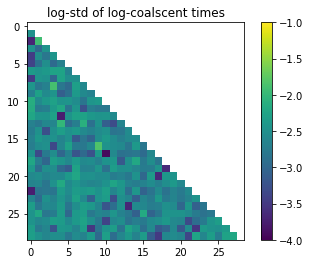

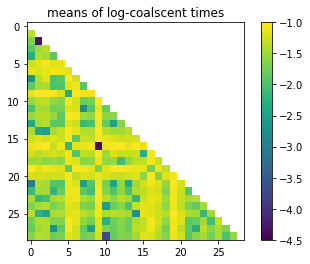

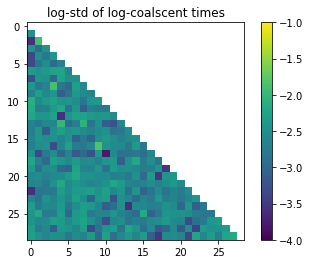

In [31]:
for theta in [optims["reparam"].theta,
              optims["reinforce"].theta,
              optims["reinforce_VIMCO"].theta]:
    
    m = deepcopy(theta[0].detach())
    m[np.triu_indices(m.shape[0])] = np.nan
    plt.imshow(m,vmin=-4.5,vmax=-1)
    plt.title("means of log-coalscent times")
    plt.colorbar()
    plt.show()

    log_sig = deepcopy(theta[1].detach())
    log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
    plt.imshow(log_sig,vmin=-4,vmax=-1)
    plt.title("log-std of log-coalscent times")
    plt.colorbar()
    plt.show()

# TEST

In [29]:
if False:
    n_particles = 10
    n_runs = 100
    h = 0.1
    i = 1
    j = 2
    k = 0

    for model in ["reinforce_VIMCO"]:
        with torch.no_grad():

            optims[model].theta[i,j,k] = optims[model].theta[i,j,k]-h
            print(optims[model].theta)

            f0s = np.zeros(n_runs)
            for l in range(n_runs):
                print(l)
                f0s[l] = logsumexp([optims[model].ELBO_reparam(1).detach() for l in range(n_particles)])

            optims[model].theta[i,j,k] = optims[model].theta[i,j,k]+2*h
            print(optims[model].theta)

            f1s = np.zeros(n_runs)
            for l in range(n_runs):
                print(l)
                f1s[l] = logsumexp([optims[model].ELBO_reparam(1).detach() for l in range(n_particles)])

            optims[model].theta[i,j,k] = optims[model].theta[i,j,k]-h

        plt.hist((f1s-f0s)/h)
        plt.title(model)
        plt.show()
        print(np.mean((f1s-f0s)/h))

In [30]:
#from scipy.stats import ttest_1samp
#ttest_1samp((f1s-f0s)/h,popmean=0.0)